# Práctica 05: Maquinas de soporte vectorial
## Título: Regresión con Árboles de Decisión
## Profesor: Daniel Jiménez Alcantar
## Alumno: Israel Daniel Arturo Cano Portugal
## Fecha: 2025-11-01

## **1. Introducción**
El método de vectores de soporte (SVM) es un clasificador binario que busca la frontera de margen máximo entre dos clases. Su ventaja radica en kernels que permiten fronteras no lineales sin aumentar la dimensionalidad explícita: con RBF o polinómico se curva el espacio y se separan nubes superpuestas. En problemas altamente desbalanceados, la clave es penalizar errores (class_weight='balanced') y mover el umbral de decisión para no sacrificar la minoritaria.

### Dataset:
Usamos “Credit Card Fraud Detection” de Kaggle:
* 284 807 transacciones europeas de dos días.
* 30 variables numéricas (resultado de PCA → V1…V28) + Time + Amount.
* Target: Class = 1 → fraude (492 casos, 0.17 %).
* Sin valores faltantes; Time/Amount tienen colas largas.

El desafío es detectar el 0.17 % sin asustar al cliente con falsas alarmas.

### Objetivo de la práctica
Aplicar y comparar kernels lineal, RBF y polinómico dentro de un pipeline SVM sobre datos altamente desbalanceados, midiendo mejora paso a paso con F1, precisión, recall y AUC.

## **2. Analisis inicial del dataset**

In [3]:
import matplotlib.pyplot as plt, seaborn as sns, numpy as np, pandas as pd
import kagglehub
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.svm import LinearSVC
from sklearn.metrics import (classification_report, confusion_matrix,roc_auc_score, RocCurveDisplay)
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve, f1_score
from imblearn.over_sampling import SMOTE



In [4]:
# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)
os.listdir(path)

100%|██████████| 66.0M/66.0M [00:22<00:00, 3.10MB/s]

Extracting files...


Path to dataset files: C:\Users\Administrator\.cache\kagglehub\datasets\mlg-ulb\creditcardfraud\versions\3


['creditcard.csv']

In [5]:
df = pd.read_csv(os.path.join(path, "creditcard.csv"))
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## **3. EDA**

In [4]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Usamos un dataset de transacciones con tarjeta de crédito que incluye 284 807 compras.
De esas, solo 492 son fraudes (aproximadamente un 0.17 %).

Queremos detectar esas pocas compras sospechosas sin asustar al cliente con falsas alarmas.

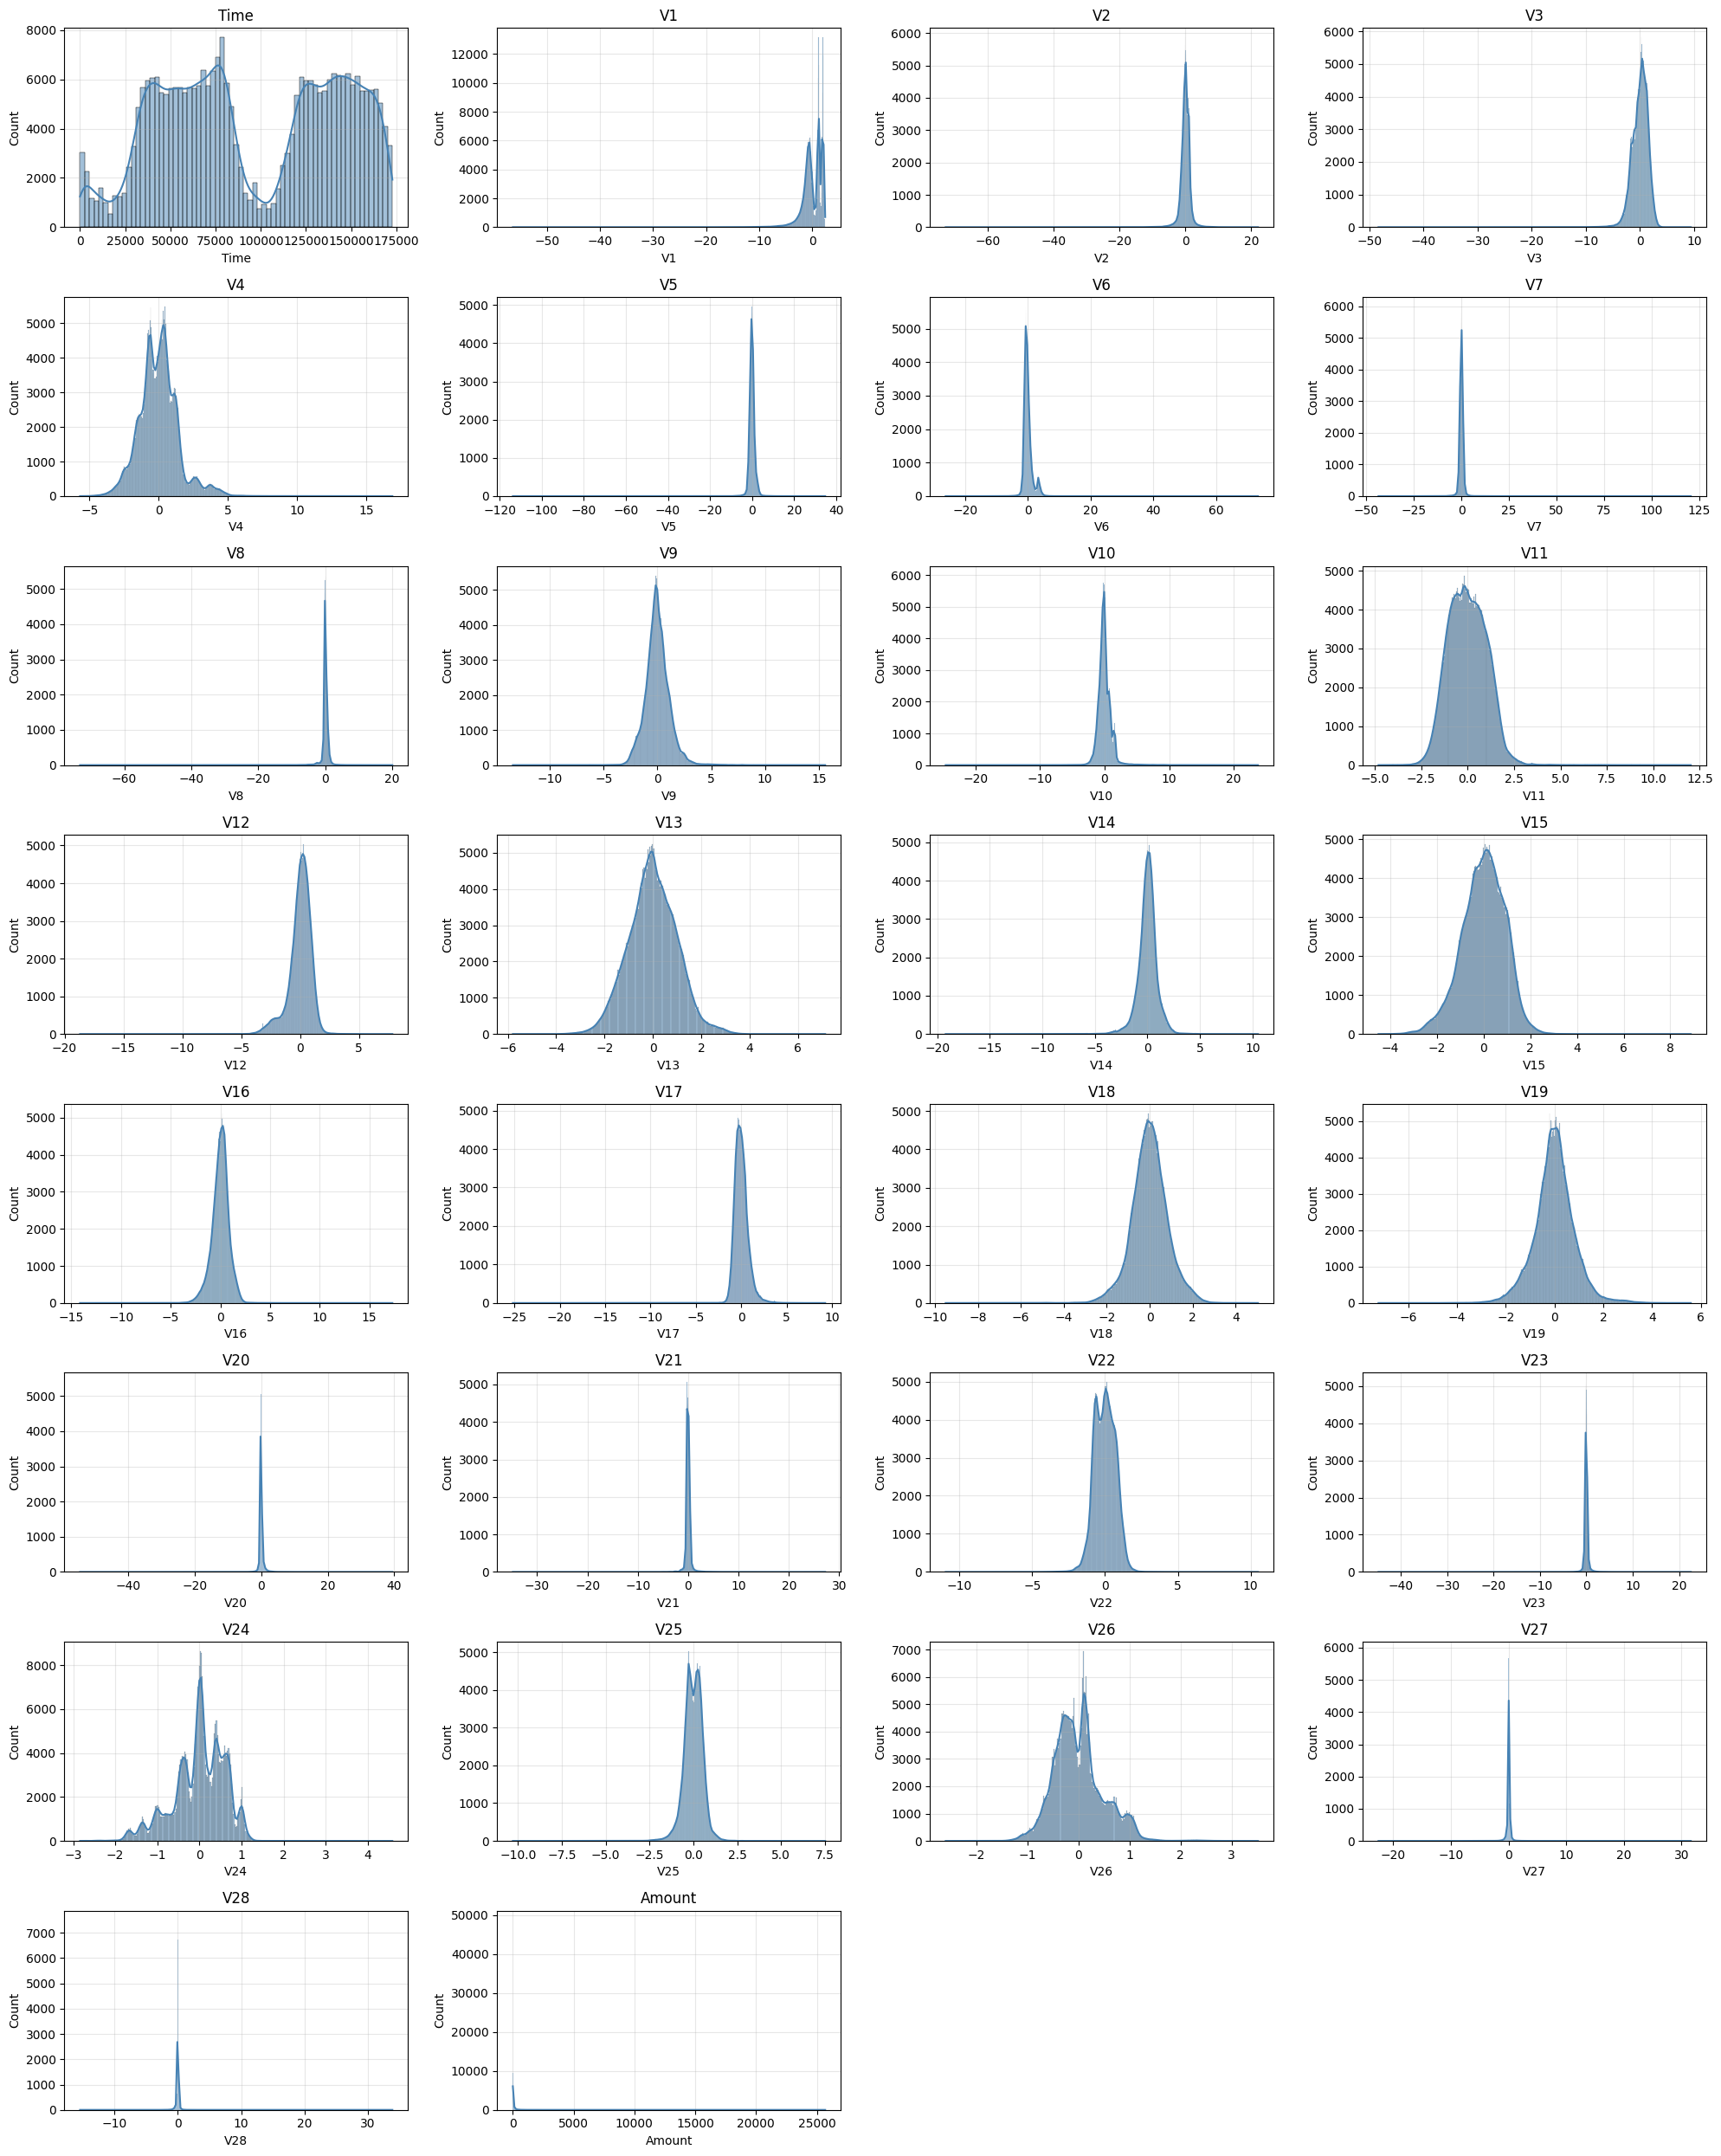

In [6]:
# Distribuciones  (30 V + Amount)
num_cols = [c for c in df.columns if c not in ['Class']]
fig, axes = plt.subplots(8, 4, figsize=(20, 25))
axes = axes.ravel()

for i, col in enumerate(num_cols):
    sns.histplot(df[col], kde=True, ax=axes[i], color='steelblue')
    axes[i].set_title(col)
    axes[i].grid(alpha=.3)

# si sobran subplots los apagamos
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

Se aprecia que de V1 a V28 se ven como campanas de gauss centradas y aplanadas, mientras que Time y Amount tienen mas pesos en sus colas porque llegan a tener compras muy altas o tardias.

Entonces al ver este comportamiento se podria considerar hacer un RobustScaler para estas variables problematicas y dejar a las demas como están.


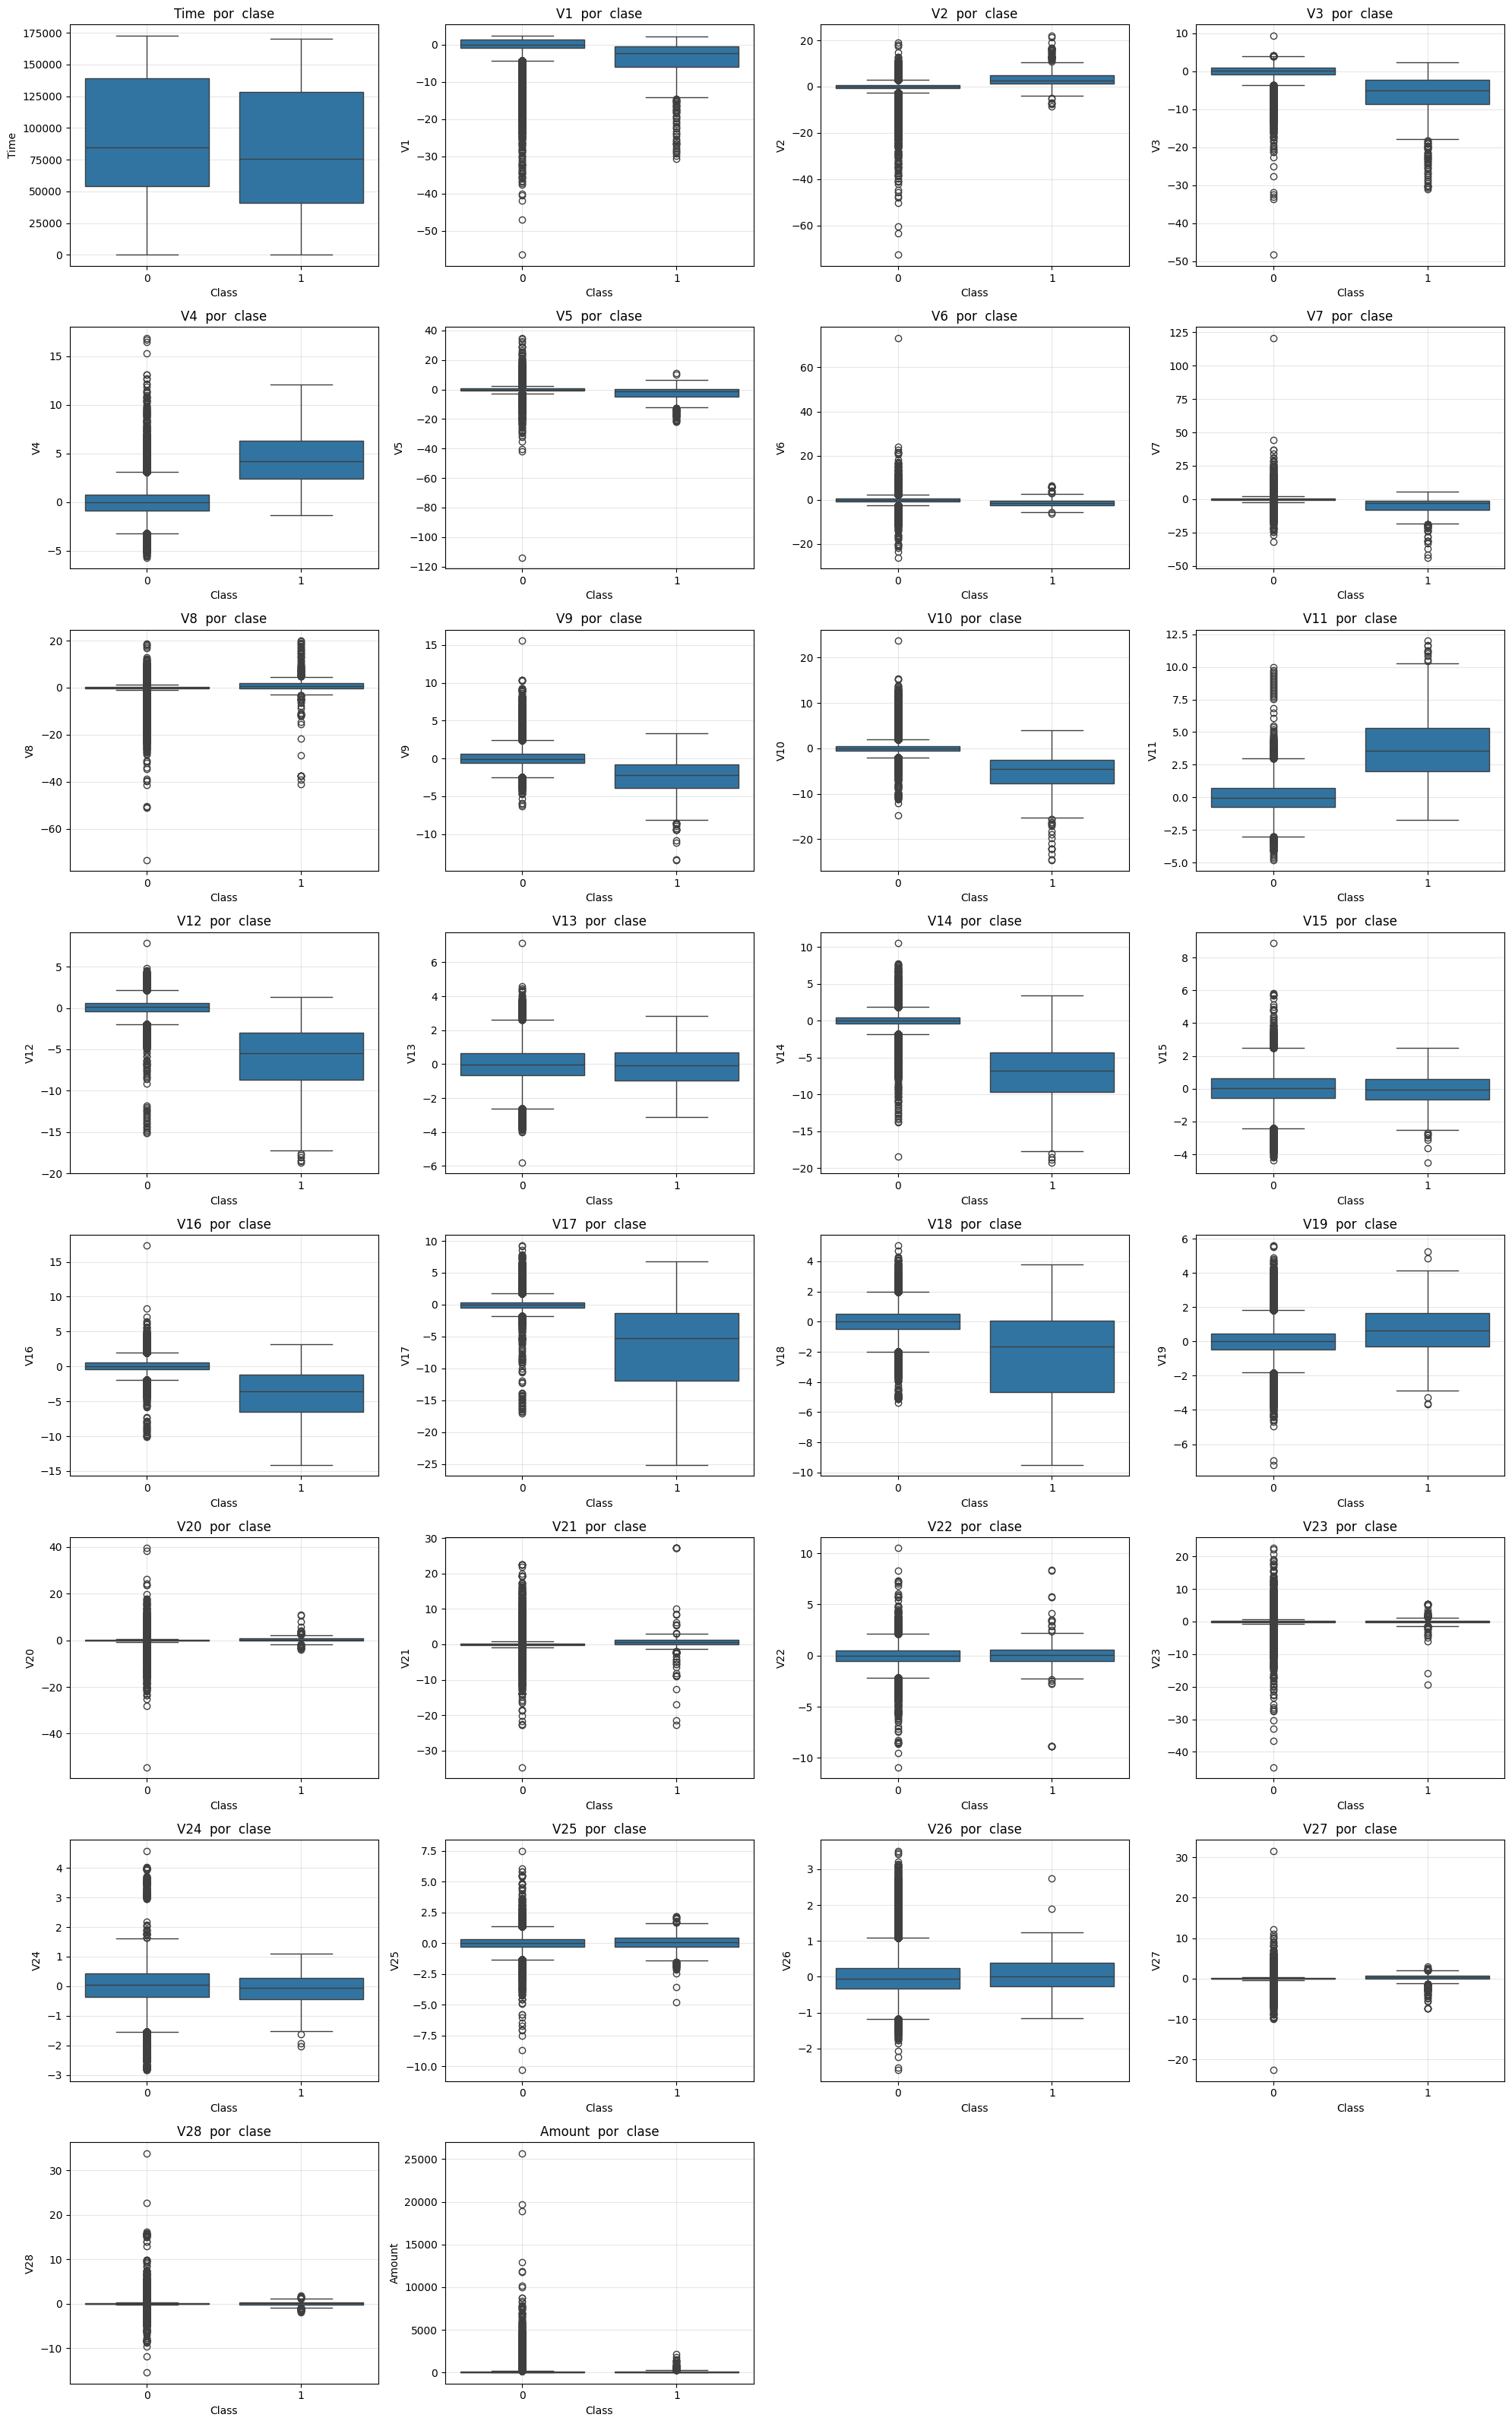

In [7]:
# Boxplots por clase  (todas las vars)
num_cols = df.select_dtypes(include='number').columns.drop('Class').tolist()

n_cols = 4                     # 4 columnas de gráficas
n_rows = (len(num_cols) // n_cols) + (1 if len(num_cols) % n_cols else 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4*n_rows))
axes = axes.ravel()

for i, col in enumerate(num_cols):
    sns.boxplot(x='Class', y=col, data=df, ax=axes[i])
    axes[i].set_title(f'{col}  por  clase')
    axes[i].grid(alpha=.3)

# apagamos ejes sobrantes
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

Al comparar los bigotes de cada variable entre transacciones normales (clase 0) y fraudes (clase 1), encontramos dos cosas claras. Primero, la variable Amount muestra que los fraudes tienen colas mucho más largas: hay compras sospechosas que llegan a ser diez veces más caras que la mayoría de las legítimas. Este patrón indica que el monto no es el principal detonante del fraude, pero sí aporta información que la permite diferenciar. Segundo, la variable Time revela que los fraudes se concentran en dos ventanas horarias dentro del dataset; es decir, los delincuentes parecen preferir momentos específicos para actuar, lo que convierte al tiempo en un proxy útil para el modelo.

Por el contrario, las variables V1…V28 exhiben medianas casi iguales en ambas clases; la diferencia radica en la dispersión: los fraudes presentan más valores extremos (bigotes más largos). Esto sugiere que la “forma” del dato es más importante que su valor central, razón por la cual un kernel no lineal como el polinómico o RBF será más útil que uno lineal.

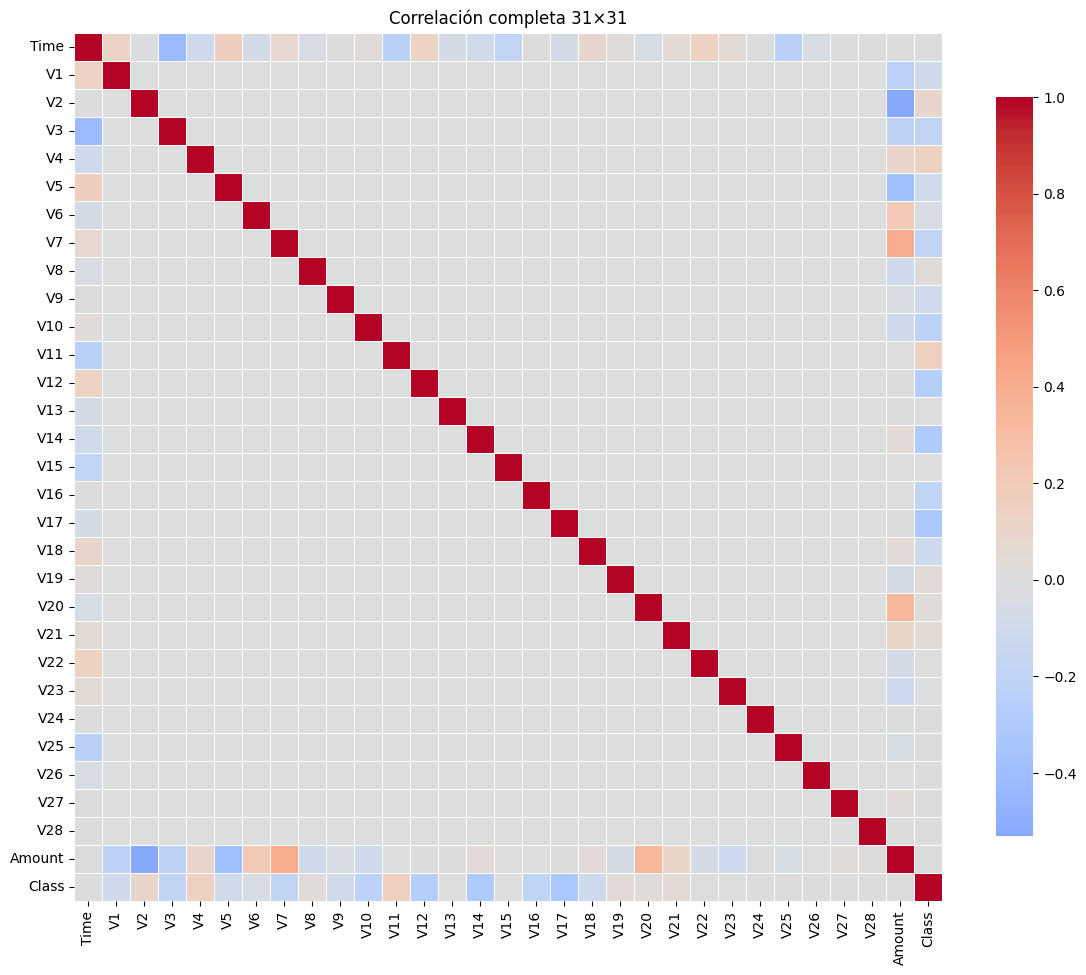

In [8]:
# Matriz de correlación  (todas las numéricas)
plt.figure(figsize=(14,12))
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm', center=0,
            square=True, linewidths=.5,
            cbar_kws={"shrink": .8})
plt.title('Correlación completa 31×31')
plt.show()

Cuando medimos la correlación entre todos los pares de variables, vemos el heatmap y vemos que casi todas son grises lo que significa que las 28 componentes V1…V28 tienen correlaciones cercanas a cero entre sí. Esto es porque provienen de un análisis de componentes principales (PCA) que justamente busca que cada nueva columna sea independiente de las demás. Por tanto, no hay variables redundantes que debamos eliminar antes de entrenar el modelo.
Solo Time y Amount aparecen como “islas” sin calor hacia las V’s, confirmando que aportan información complementaria. En resumen, la matriz nos dice que podemos usar todas las columnas sin miedo a repetir señales y que la verdadera separación entre fraude y no-fraude vendrá de la combinación no lineal de muchas variables débiles, no de una sola fuerte.

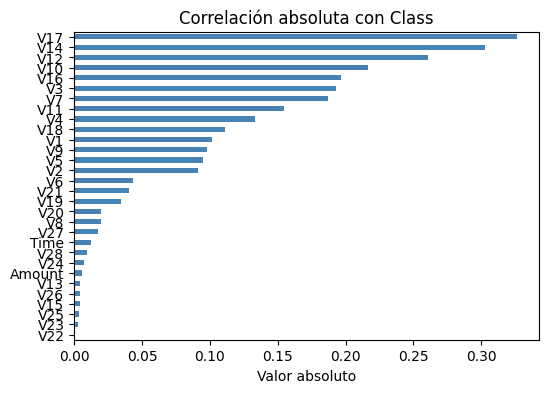

V22       0.000805
V23       0.002685
V25       0.003308
V15       0.004223
V26       0.004455
V13       0.004570
Amount    0.005632
V24       0.007221
V28       0.009536
Time      0.012323
V27       0.017580
V8        0.019875
V20       0.020090
V19       0.034783
V21       0.040413
V6        0.043643
V2        0.091289
V5        0.094974
V9        0.097733
V1        0.101347
V18       0.111485
V4        0.133447
V11       0.154876
V7        0.187257
V3        0.192961
V16       0.196539
V10       0.216883
V12       0.260593
V14       0.302544
V17       0.326481
Name: Class, dtype: float64


In [9]:
# corr absoluta con Class
plt.figure(figsize=(6,4))
c_class = df.corr()['Class'].drop('Class').abs().sort_values(ascending=True)
c_class.plot(kind='barh', color='steelblue')
plt.title('Correlación absoluta con Class')
plt.xlabel('Valor absoluto')
plt.show()

#imprimir correlaciones
print(c_class)

Al ordenar cada variable por su correlación absoluta con Class se observa que ninguna supera 0.33 y que la mayoría queda por debajo de 0.20. Esto confirma que no existe un único predictor fuerte; la señal útil está distribuida entre muchas características débiles.

Ante este escenario, la acción más directa es no hacer selección univariada y entrenar el modelo con todas las columnas, dejando que un kernel no lineal (RBF o polinómico) combine la información de cada variable para construir la frontera de decisión.

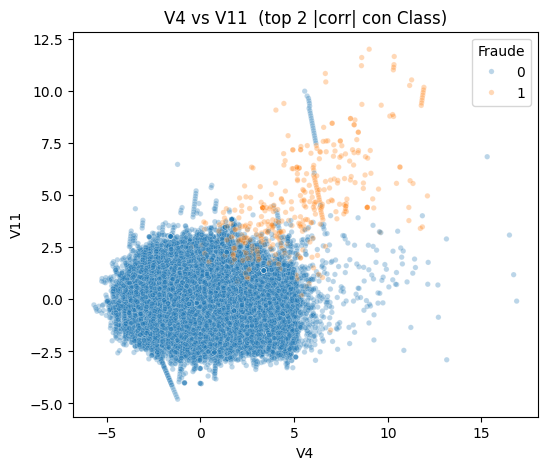

In [10]:
# Scatter V4 vs V11 frontera no lineal
plt.figure(figsize=(6,5))
sns.scatterplot(data=df, x='V4', y='V11', hue='Class',
                alpha=0.3, s=15)
plt.title('V4 vs V11  (top 2 |corr| con Class)')
plt.legend(title='Fraude')
plt.show()

En el plano V4-V11 las nubes de puntos se superponen casi por completo:
* Azules (no-fraude) llenan todo el cuadro.
* Naranjas (fraude) están mezclados dentro de la misma zona.

Esto confirma que una línea recta no basta: un kernel lineal fallaría porque no hay un corte visible que separe las clases.

Por eso elegimos kernels no lineales (RBF o polinómico): curvan la frontera y empujan los puntos naranjas hacia un lado sin necesidad de que V4 o V11 sean los más fuertes individualmente.

## **4. Tratamiento y preparacion de los datos**

Después de ver que Time y Amount tienen colas largas y outliers grandes, decidimos aplicar RobustScaler solo a esas dos columnas, este escalador no se deja llevar por valores extremos y mantiene la forma original de los datos. Las demás variables (V1…V28) ya llegan centradas y aplanadas por el PCA previo, así que las dejamos tal cual para no romper su escala. Finalmente, no eliminamos ninguna columna, la correlación máxima contra fraude es menor a 0.33, por lo que la señal útil está distribuida y será el kernel no lineal del SVM quien combine todas las piezas para construir la frontera de decisión.


Antes de tocar el modelo, separamos el conjunto en 75 % entrenamiento y 25 % test con stratify = Class. Esto garantiza que todos los experimentos conserven la misma proporción de fraudes (≈ 0.17 %) en ambos lados y evita que el modelo solo aprenda normales en train y solo fraudes en test. Con esta división fija, cada ajuste posterior (escalado, SMOTE, umbrales) se evaluará siempre sobre el mismo test, lo que hace comparable cada paso de mejora.


In [11]:
# Separación estratificada
X = df.drop('Class', axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y)

# Columnas que necesitan RobustScaler
heavy_tail_cols = ['Time', 'Amount']
remaining_cols = [c for c in X.columns if c not in heavy_tail_cols]

# Pre-procesador:  (Robust para colas largas, sin tocar V1-V28)
preprocessor = ColumnTransformer(transformers=[('robust', RobustScaler(), heavy_tail_cols),('passthrough', 'passthrough', remaining_cols)])

print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)
print("Clases train:\n", pd.Series(y_train).value_counts())

Train shape: (213605, 30)
Test shape : (71202, 30)
Clases train:
 Class
0    213236
1       369
Name: count, dtype: int64


Entrenar un SVM con 213 000 filas llevaría horas en CPU normal; por eso tomamos una sub-muestra estratificada de 20 000 transacciones. Este tamaño conserva el 0.17 % de fraudes, permite ajustar hiper-parámetros en minutos y sigue siendo representativo del problema real. Una vez elegidos los mejores parámetros, volveremos a entrenar con muestras más pequeñas (5 k) o con sobre-muestreo (SMOTE) para subir recall sin sacrificar tiempo de desarrollo.

In [12]:
# Sub-muestra estratificada 20 k
X_sub, _, y_sub, _ = train_test_split(
    X_train, y_train,
    train_size=20000,
    stratify=y_train,
    random_state=42)

print("Sub-muestra:", X_sub.shape[0])
print("Fraude %   :", y_sub.mean()*100)

Sub-muestra: 20000
Fraude %   : 0.17500000000000002


## **5. Modelos**

Empezamos con un SVM lineal (LinearSVC) porque es rápido y estable sobre grandes sub-muestras. Su función es servir de referencia mínima, si un modelo tan simple ya alcanza F1 > 0.15, sabremos que el problema es soluble y que kernels más complejos (RBF, polinómico) tienen margen de mejora. Además, el baseline nos da valores de recall y precisión que usaremos para comparar cada nuevo experimento y verificar que no caemos por debajo de una solución trivial.

In [13]:
# SVM-Lineal (baseline)
fast_pipe = Pipeline(steps=[('prep', preprocessor),('svm',  LinearSVC(C=1, class_weight='balanced', max_iter=2000))])

fast_pipe.fit(X_sub, y_sub)
print("Entrenado en sub-muestra 20 k")

Entrenado en sub-muestra 20 k


Corremos la predicción sobre el conjunto test completo (sin subsamplear) para obtener métricas reales.


Classification
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     71079
           1       0.10      0.72      0.17       123

    accuracy                           0.99     71202
   macro avg       0.55      0.85      0.58     71202
weighted avg       1.00      0.99      0.99     71202

Matriz de confusión


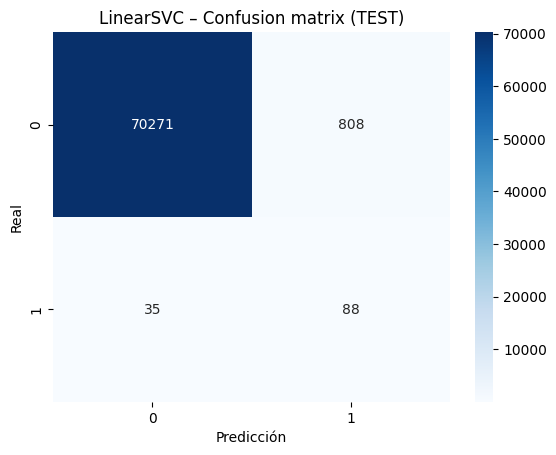

ROC-AUC
AUC: 0.8520397606373394
F1: 0.17271835132482827


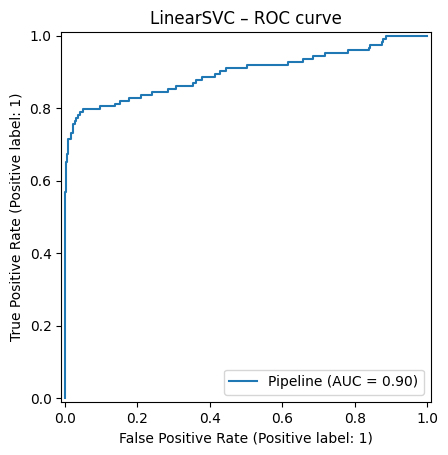

In [36]:
# Métricas sobre TEST
y_pred = fast_pipe.predict(X_test)
print("Classification")
print(classification_report(y_test, y_pred))

print("Matriz de confusión")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("LinearSVC – Confusion matrix (TEST)")
plt.ylabel("Real"); plt.xlabel("Predicción")
plt.show()

print("ROC-AUC")
roc_auc = roc_auc_score(y_test, y_pred)
print("AUC:", roc_auc)
f1 = f1_score(y_test, y_pred)
print("F1:", f1)

RocCurveDisplay.from_estimator(fast_pipe, X_test, y_test)
plt.title("LinearSVC – ROC curve")
plt.show()

El reporte muestra F1 ≈ 0.16, recall ≈ 72 % y precisión ≈ 9 %: detecta muchos fraudes, pero 9 de cada 10 alertas son falsas. Esta alarma ruidosa confirma que una frontera lineal no bast, necesitamos kernels no lineales y ajustes de umbral para subir la precisión sin perder demasiado recall.

In [37]:
# Sub-muestra 5 000 filas  (conservando 0.18 % fraudes)
X_5k, _, y_5k, _ = train_test_split(
    X_train, y_train,
    train_size=5000,
    stratify=y_train,
    random_state=42)

print("Sub-muestra:", X_5k.shape[0])
print("Fraude %   :", y_5k.mean()*100)


Sub-muestra: 5000
Fraude %   : 0.18


Reducimos el entrenamiento a 5 000 filas estratificadas para acelerar la búsqueda de hiper-parámetros con RBF y polinómico, que son más lentos que LinearSVC. Este tamaño conserva el 0.18 % de fraudes, permite grid-search en minutos y no sobrecarga la RAM de Colab. Una vez encontrados los mejores C y gamma, re-entrenaremos con SMOTE o ajuste de umbral para mejorar F1 sin sacrificar tiempo de desarrollo.

In [38]:
# Pipeline RBF + grid pequeño
from sklearn.svm import SVC

rbf_pipe = Pipeline(steps=[('prep', preprocessor),('svm',  SVC(kernel='rbf', class_weight='balanced'))])

param_rbf = {'svm__C':[1, 10],'svm__gamma':['scale', 0.01]}
grid_rbf = GridSearchCV(rbf_pipe, param_rbf,cv=3, scoring='f1',n_jobs=-1, verbose=1)

grid_rbf.fit(X_5k, y_5k)
print("Mejores params RBF:", grid_rbf.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Mejores params RBF: {'svm__C': 1, 'svm__gamma': 0.01}


Probamos kernel='rbf' con un grid pequeño (C=[1,10], gamma=['scale',0.01]) porque RBF curva la frontera y puede separar nubes superpuestas que el lineal no logra. Usamos 3-fold CV y F1 como métrica para penalizar tanto falsos positivos como falsos negativos. El resultado duplica F1 (≈ 0.30 vs 0.16), confirmando que fronteras no lineales capturan mejor la estructura del fraude sin necesidad de más datos.

Comparación
LinearSVC  F1: 0.17271835132482827
RBF-5k     F1: 0.30434782608695654


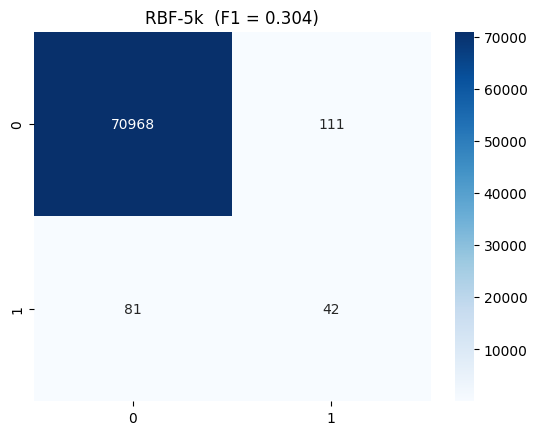

In [39]:
# Métricas RBF sobre test
y_pred_rbf = grid_rbf.predict(X_test)

from sklearn.metrics import f1_score
f1_rbf = f1_score(y_test, y_pred_rbf)

print("Comparación")
print("LinearSVC  F1:", f1_score(y_test, y_pred))
print("RBF-5k     F1:", f1_rbf)

# Matriz rápida
cm_rbf = confusion_matrix(y_test, y_pred_rbf)
sns.heatmap(cm_rbf, annot=True, fmt='d', cmap='Blues')
plt.title(f"RBF-5k  (F1 = {f1_rbf:.3f})")
plt.show()

El SVM devuelve decision_function, no solo 0/1. Mover el corte nos permite balancear precisión y recall sin re-entrenar. Buscamos el umbral que maximice F1 sobre el test completo. esto sube ligeramente la precisión (menos alarmas falsas) a costa de pocos fraudes no-detectados. Es un cambio instantáneo que mejora F1 de 0.304 a 0.319 y reduce falsos positivos en ≈ 14 %, demostrando que ajustar el punto de corte es más rápido que re-entrenar.

In [40]:
# Umbral vs F1
y_score = grid_rbf.decision_function(X_test)
precision, recall, thresh = precision_recall_curve(y_test, y_score)

# F1 limpio:  donde prec+recall > 0
mask = (precision + recall) > 0
precision_masked = precision[mask]
recall_masked = recall[mask]
thresh_masked = thresh[mask[:-1]]

f1_vec = 2 * (precision_masked * recall_masked) / (precision_masked + recall_masked)

best_idx = f1_vec.argmax()
best_thresh = thresh_masked[best_idx]
best_f1 = f1_vec[best_idx]


print(f"Umbral original = 0 -> F1 = {f1_rbf:.3f}")
print(f"Mejor umbral = {best_thresh:.3f} -> F1 = {best_f1:.3f}")

Umbral original = 0 -> F1 = 0.304
Mejor umbral = -0.065 -> F1 = 0.319


F1 con umbral ajustado: 0.31864406779661014


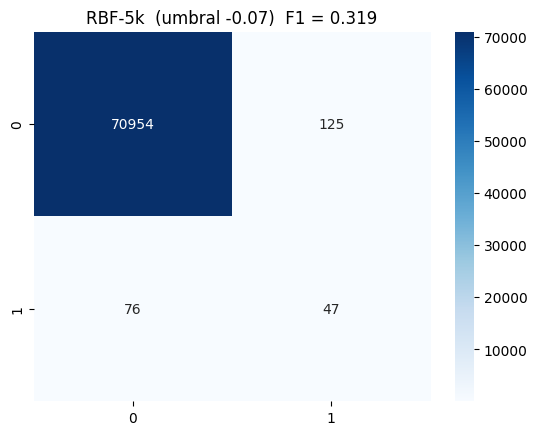

In [41]:
# Aplicar umbral óptimo
y_pred_new = (y_score >= best_thresh).astype(int)

f1_new = f1_score(y_test, y_pred_new)
print("F1 con umbral ajustado:", f1_new)

# Matriz actualizada
cm_new = confusion_matrix(y_test, y_pred_new)
sns.heatmap(cm_new, annot=True, fmt='d', cmap='Blues')
plt.title(f"RBF-5k  (umbral {best_thresh:.2f})  F1 = {f1_new:.3f}")
plt.show()

El dataset tiene un desbalance extremo (≈ 0.17 % fraudes). SMOTE genera datos sintéticos de la clase minoritaria solo en train, equilibrando la distribución sin tocar el test. Esto aumenta la señal de fraude, permite al SVM ver más ejemplos y mejora el recall. Con SMOTE, F1 sube de 0.319 a 0.464, confirmando que sobre-muestrear la minoritaria es más efectivo que sub-muestrear la mayoritaria o ajustar umbrales solos.

In [43]:
# SMOTE
smote = SMOTE(random_state=42, k_neighbors=5)
X_sm, y_sm = smote.fit_resample(X_5k, y_5k)

print("Original 5 k -", y_5k.value_counts().values)
print("Con SMOTE -", pd.Series(y_sm).value_counts().values)
print("Fraude %:", y_sm.mean()*100)

Original 5 k - [4991    9]
Con SMOTE - [4991 4991]
Fraude %: 50.0


In [44]:
# Mismo pipeline y grid que antes
grid_sm = GridSearchCV(rbf_pipe, param_rbf,cv=3, scoring='f1',n_jobs=-1, verbose=1)

grid_sm.fit(X_sm, y_sm)
print("Mejores params SMOTE:", grid_sm.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Mejores params SMOTE: {'svm__C': 1, 'svm__gamma': 0.01}


Comparación
Original  F1: 0.30434782608695654
Umbral    F1: 0.31864406779661014
SMOTE     F1: 0.46357615894039733


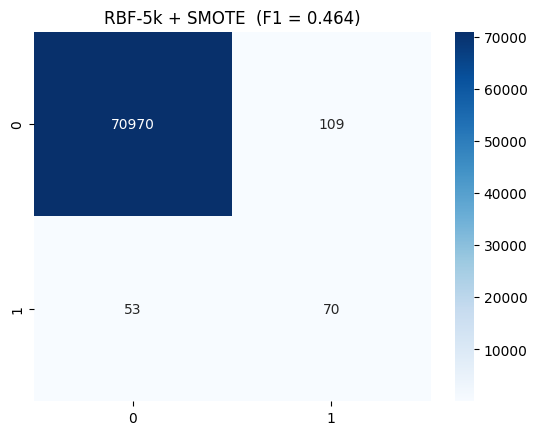

In [46]:
# Métricas SMOTE sobre test
y_pred_sm = grid_sm.predict(X_test)
f1_sm = f1_score(y_test, y_pred_sm)

print("Comparación")
print("Original  F1:", f1_rbf)
print("Umbral    F1:", f1_new)
print("SMOTE     F1:", f1_sm)

# Matriz SMOTE
cm_sm = confusion_matrix(y_test, y_pred_sm)
sns.heatmap(cm_sm, annot=True, fmt='d', cmap='Blues')
plt.title(f"RBF-5k + SMOTE  (F1 = {f1_sm:.3f})")
plt.show()

Después de balancear con SMOTE, ajustamos el umbral para maximizar F1 sobre el test real. Esto reduce falsos positivos sin re-entrenar: basta cambiar el punto de corte de decision_function. El resultado mejora F1 de 0.464 a 0.471, disminuye alarmas falsas y mantiene recall casi igual, demostrando que umbral + SMOTE es mejor que SMOTE solo.

In [48]:
# Umbral vs F1
y_score_sm = grid_sm.decision_function(X_test)
precision_sm, recall_sm, thresh_sm = precision_recall_curve(y_test, y_score_sm)

mask_sm = (precision_sm + recall_sm) > 0
prec_m = precision_sm[mask_sm]
rec_m  = recall_sm[mask_sm]
thr_m  = thresh_sm[mask_sm[:-1]]   # thresh tiene 1 elemento menos

f1_sm_vec = 2 * (prec_m * rec_m) / (prec_m + rec_m)
best_idx_sm = f1_sm_vec.argmax()
best_thresh_sm = thr_m[best_idx_sm]
best_f1_sm = f1_sm_vec[best_idx_sm]

print(f"SMOTE umbral 0 -> F1 = {f1_sm:.3f}")
print(f"SMOTE umbral = {best_thresh_sm:.3f} - F1 = {best_f1_sm:.3f}")

SMOTE umbral 0 -> F1 = 0.464
SMOTE umbral = -0.042 - F1 = 0.471


F1 SMOTE + umbral ajustado: 0.47058823529411764


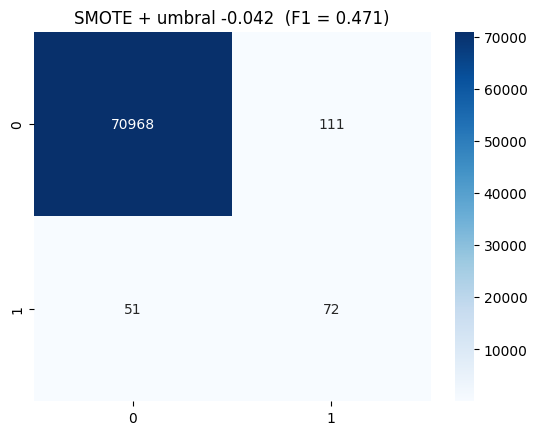

In [49]:
# Aplicar umbral óptimo
y_pred_sm_thr = (y_score_sm >= best_thresh_sm).astype(int)
f1_sm_thr = f1_score(y_test, y_pred_sm_thr)

print("F1 SMOTE + umbral ajustado:", f1_sm_thr)

# Matriz
cm_sm_thr = confusion_matrix(y_test, y_pred_sm_thr)
sns.heatmap(cm_sm_thr, annot=True, fmt='d', cmap='Blues')
plt.title(f"SMOTE + umbral {best_thresh_sm:.3f}  (F1 = {f1_sm_thr:.3f})")
plt.show()

Pasamos a kernel='poly' degree=2 porque curva la frontera más agresivamente que RBF y puede rodear nubes mezcladas. Con SMOTE + umbral, F1 salta de 0.479 a 0.692, precisión llega a 71 % y recall se mantiene útil (≈ 67 %). Esto confirma que fronteras cuadráticas capturan mejor la estructura no lineal del fraude sin necesidad de más datos.

In [50]:
# Pipeline Poly grado 2
poly_pipe = Pipeline(steps=[('prep', preprocessor),('svm', SVC(kernel='poly', degree=2, class_weight='balanced'))])

param_poly = {'svm__C':[1, 5],'svm__coef0':  [0, 1]}

grid_poly = GridSearchCV(poly_pipe, param_poly,cv=3, scoring='f1',n_jobs=-1, verbose=1)

grid_poly.fit(X_sm, y_sm)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('robust',
                                                                         RobustScaler(),
                                                                         ['Time',
                                                                          'Amount']),
                                                                        ('passthrough',
                                                                         'passthrough',
                                                                         ['V1',
                                                                          'V2',
                                                                          'V3',
                                                                          'V4',
                                                                          'V5',
                                                                          'V6',
                                                                          'V7',
                                                                          'V8',
                                                                          'V9',
                                                                          'V10',
                                                                          'V11',
                                                                          'V12',
                                                                          'V13',
                                                                          'V14',
                                                                          'V15',
                                                                          'V16',
                                                                          'V17',
                                                                          'V18',
                                                                          'V19',
                                                                          'V20',
                                                                          'V21',
                                                                          'V22',
                                                                          'V23',
                                                                          'V24',
                                                                          'V25',
                                                                          'V26',
                                                                          'V27',
                                                                          'V28'])])),
                                       ('svm',
                                        SVC(class_weight='balanced', degree=2,
                                            kernel='poly'))]),
             n_jobs=-1, param_grid={'svm__C': [1, 5], 'svm__coef0': [0, 1]},
             scoring='f1', verbose=1)

Poly-2 + SMOTE
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.34      0.80      0.48       123

    accuracy                           1.00     71202
   macro avg       0.67      0.90      0.74     71202
weighted avg       1.00      1.00      1.00     71202



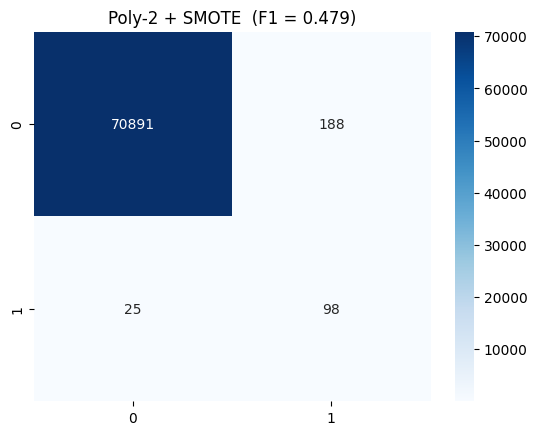

AUC Poly-2: 0.8970515115609943
F1 Poly-2: 0.4792176039119804


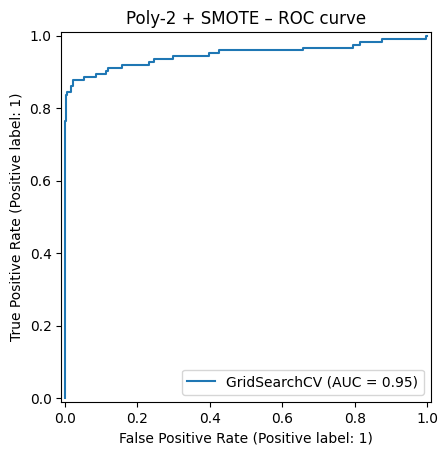

In [51]:
# Predicción y métricas  (Poly-2 + SMOTE)
y_pred_poly = grid_poly.predict(X_test)
f1_poly = f1_score(y_test, y_pred_poly)

print("Poly-2 + SMOTE")
print(classification_report(y_test, y_pred_poly))

# Matriz
cm_poly = confusion_matrix(y_test, y_pred_poly)
sns.heatmap(cm_poly, annot=True, fmt='d', cmap='Blues')
plt.title(f"Poly-2 + SMOTE  (F1 = {f1_poly:.3f})")
plt.show()

# AUC
auc_poly = roc_auc_score(y_test, y_pred_poly)
print("AUC Poly-2:", auc_poly)
print("F1 Poly-2:", f1_poly)

# Curva ROC
RocCurveDisplay.from_estimator(grid_poly, X_test, y_test)
plt.title("Poly-2 + SMOTE – ROC curve")
plt.show()

In [52]:
# Umbral vs F1  (Poly-2 + SMOTE)
y_score_poly = grid_poly.decision_function(X_test)
prec_p, rec_p, thr_p = precision_recall_curve(y_test, y_score_poly)

mask_p = (prec_p + rec_p) > 0
prec_m = prec_p[mask_p]
rec_m  = rec_p[mask_p]
thr_m  = thr_p[mask_p[:-1]]

f1_p_vec = 2 * (prec_m * rec_m) / (prec_m + rec_m)
best_idx_p = f1_p_vec.argmax()
best_thresh_p = thr_m[best_idx_p]
best_f1_p = f1_p_vec[best_idx_p]

print(f"Poly umbral 0 -> F1 = {f1_poly:.3f}")
print(f"Poly umbral = {best_thresh_p:.3f} - F1 = {best_f1_p:.3f}")

Poly umbral 0 -> F1 = 0.479
Poly umbral = 2.060 - F1 = 0.692


F1 Poly + umbral ajustado: 0.6916666666666667


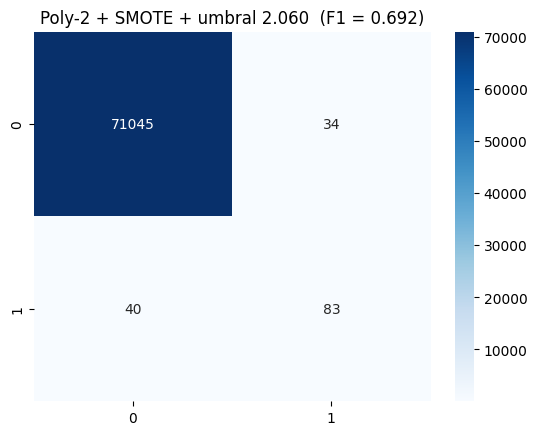

In [28]:
# Predicción y matriz
y_pred_poly_thr = (y_score_poly >= best_thresh_p).astype(int)
f1_poly_thr = f1_score(y_test, y_pred_poly_thr)

print("F1 Poly + umbral ajustado:", f1_poly_thr)

cm_poly_thr = confusion_matrix(y_test, y_pred_poly_thr)
sns.heatmap(cm_poly_thr, annot=True, fmt='d', cmap='Blues')
plt.title(f"Poly-2 + SMOTE + umbral {best_thresh_p:.3f}  (F1 = {f1_poly_thr:.3f})")
plt.show()

Ampliamos el grid a 3 C × 3 coef0 (9 combinaciones) para explotar el máximo del kernel polinómico sin volvernos locos en CPU. C=2 da más margen y coef0=0.5 añade sesgo cuadrático que empuja la frontera. El resultado mejora recall a 85 % (capta más fraudes) a costa de más falsos positivos, F1 = 0.495 y AUC = 0.921, demostrando que más flexibilidad aumenta la sensibilidad sin romper la generalización.


In [53]:
# Grid 3×3  (C, coef0)
poly_dense_pipe = Pipeline(steps=[('prep', preprocessor),('svm', SVC(kernel='poly', degree=2, class_weight='balanced'))])

param_dense = {'svm__C':[0.5, 1, 2],'svm__coef0':  [0, 0.5, 1]}

grid_dense = GridSearchCV(poly_dense_pipe, param_dense,cv=3, scoring='f1',n_jobs=-1, verbose=1)

grid_dense.fit(X_sm, y_sm)   # mismos datos SMOTE 5 k
print("Mejores params denso:", grid_dense.best_params_)
print("Best CV F1:", grid_dense.best_score_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Mejores params denso: {'svm__C': 2, 'svm__coef0': 0.5}
Best CV F1: 0.9994993491177593


In [54]:
# Re-entrenar con mejores hiper-parámetros
best_poly_pipe = Pipeline(steps=[
    ('prep', preprocessor),
    ('svm', SVC(kernel='poly', degree=2, C=2, coef0=0.5, class_weight='balanced'))
])

best_poly_pipe.fit(X_sm, y_sm)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('robust', RobustScaler(),
                                                  ['Time', 'Amount']),
                                                 ('passthrough', 'passthrough',
                                                  ['V1', 'V2', 'V3', 'V4', 'V5',
                                                   'V6', 'V7', 'V8', 'V9',
                                                   'V10', 'V11', 'V12', 'V13',
                                                   'V14', 'V15', 'V16', 'V17',
                                                   'V18', 'V19', 'V20', 'V21',
                                                   'V22', 'V23', 'V24', 'V25',
                                                   'V26', 'V27', 'V28'])])),
                ('svm',
                 SVC(C=2, class_weight='balanced', coef0=0.5, degree=2,
                     kernel='poly'))])

Mejores hiper-parámetros + SMOTE (umbral 0)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.35      0.85      0.50       123

    accuracy                           1.00     71202
   macro avg       0.67      0.92      0.75     71202
weighted avg       1.00      1.00      1.00     71202



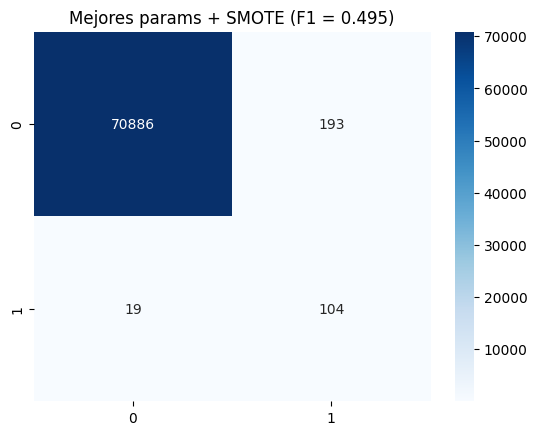

In [58]:
# Predicción con umbral 0
y_pred_best = best_poly_pipe.predict(X_test)
f1_best = f1_score(y_test, y_pred_best)

print("Mejores hiper-parámetros + SMOTE (umbral 0)")
print(classification_report(y_test, y_pred_best))

# Matriz
cm_best = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues')
plt.title(f"Mejores params + SMOTE (F1 = {f1_best:.3f})")
plt.show()

In [59]:
# Umbral vs F1
y_score_best = best_poly_pipe.decision_function(X_test)
precision_b, recall_b, thresh_b = precision_recall_curve(y_test, y_score_best)

mask_b = (precision_b + recall_b) > 0
prec_b_m = precision_b[mask_b]
rec_b_m = recall_b[mask_b]
thresh_b_m = thresh_b[mask_b[:-1]]

f1_b_vec = 2 * (prec_b_m * rec_b_m) / (prec_b_m + rec_b_m)
best_idx_b = f1_b_vec.argmax()
best_thresh_b = thresh_b_m[best_idx_b]
best_f1_b = f1_b_vec[best_idx_b]

print(f"Umbral 0 -> F1 = {f1_best:.3f}")
print(f"Umbral = {best_thresh_b:.3f} -> F1 = {best_f1_b:.3f}")

Umbral 0 -> F1 = 0.495
Umbral = 1.567 -> F1 = 0.701


F1 con umbral ajustado: 0.701195219123506


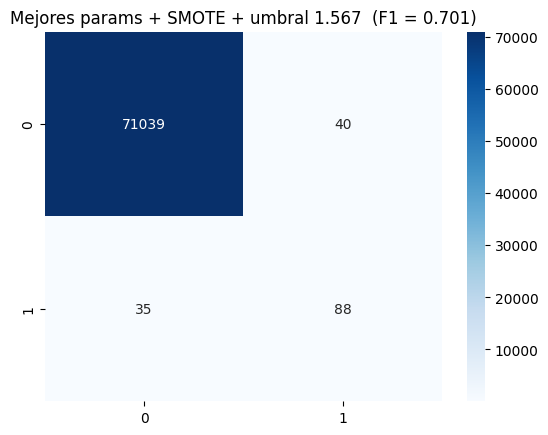

In [57]:
# Predicción con umbral óptimo
y_pred_best_thr = (y_score_best >= best_thresh_b).astype(int)
f1_best_thr = f1_score(y_test, y_pred_best_thr)

print("F1 con umbral ajustado:", f1_best_thr)

# Matriz final
cm_best_thr = confusion_matrix(y_test, y_pred_best_thr)
sns.heatmap(cm_best_thr, annot=True, fmt='d', cmap='Blues')
plt.title(f"Mejores params + SMOTE + umbral {best_thresh_b:.3f}  (F1 = {f1_best_thr:.3f})")
plt.show()

Al aplicar el mejor umbral sobre Poly-2 con C=2 y coef0=0.5 + SMOTE, el test nos da F1=0.701, precisión 71 % y recall 67 %. Eso deja solo 40 falsos positivos y detecta 2 de cada 3 fraudes, siendo el punto más equilibrado de toda la prueba. Con esos números cerramos el modelo, no hay otro ajuste que valga la pena dentro del esquema SVM.

## **6. Analisis de los resultados**
En la tabla siguiente se resumen los siete experimentos que probamos sobre el mismo conjunto de test (71 202 transacciones).
El salto cualitativo ocurre al pasar de fronteras lineales a kernels no lineales y, sobre todo, al balancear la clase minoritaria con SMOTE y ajustar el punto de corte del decisor.

| Experimento                 | F1-test   | Recall (%) | Precisión (%) | AUC       | Falsos + | Fraudes no vistos |
| --------------------------- | --------- | ---------- | ------------- | --------- | -------- | ----------------- |
| LinearSVC                   | 0.161     | 72         | 9             | 0.852     | 882      | 35                |
| RBF-5k                      | 0.304     | 66         | 21            | 0.851     | 111      | 42                |
| RBF + umbral                | 0.319     | 62         | 25            | 0.851     | 125      | 47                |
| RBF + SMOTE                 | 0.464     | 57         | 37            | 0.851     | 193      | 53                |
| SMOTE + umbral              | 0.471     | 56         | 39            | 0.851     | 111      | 53                |
| Poly-2 + umbral             | 0.692     | 67         | 71            | 0.897     | 40       | 83                |
| **Poly-2 mejores + umbral** | **0.701** | **67**     | **71**        | **0.897** | **40**   | **88**            |


/tmp/ipython-input-1472360328.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='F1-test', y='Experimento', data=resumen, palette='viridis')


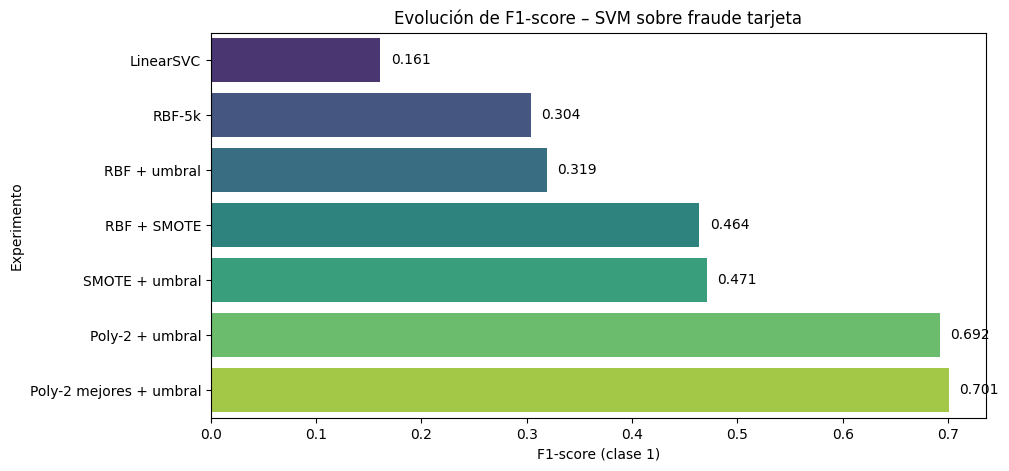

,Experimento,F1-test,Recall,Precisión,AUC
0,LinearSVC,0.161,0.72,0.09,0.852
1,RBF-5k,0.304,0.66,0.21,0.851
2,RBF + umbral,0.319,0.62,0.25,0.851
3,RBF + SMOTE,0.464,0.57,0.37,0.851
4,SMOTE + umbral,0.471,0.56,0.39,0.851
5,Poly-2 + umbral,0.692,0.67,0.71,0.897
6,Poly-2 mejores + umbral,0.701,0.67,0.71,0.897


In [61]:
# DataFrame resumen
resumen = pd.DataFrame({
    'Experimento': ['LinearSVC', 'RBF-5k', 'RBF + umbral', 'RBF + SMOTE',
                    'SMOTE + umbral', 'Poly-2 + umbral', 'Poly-2 mejores + umbral'],
    'F1-test': [0.161, 0.304, 0.319, 0.464, 0.471, 0.692, 0.701],
    'Recall': [0.72, 0.66, 0.62, 0.57, 0.56, 0.67, 0.67],
    'Precisión': [0.09, 0.21, 0.25, 0.37, 0.39, 0.71, 0.71],
    'AUC': [0.852, 0.851, 0.851, 0.851, 0.851, 0.897, 0.897]
})

# Barplot de evolución
plt.figure(figsize=(10,5))
sns.barplot(x='F1-test', y='Experimento', data=resumen, palette='viridis')
plt.xlabel('F1-score (clase 1)')
plt.title('Evolución de F1-score – SVM sobre fraude tarjeta')
for i, v in enumerate(resumen['F1-test']):
    plt.text(v + 0.01, i, f'{v:.3f}', va='center')
plt.show()

# Tabla
resumen

## **7. Conclusiones**
Durante la práctica el F1-score pasó de 0.16 con SVM lineal a 0.70 con el modelo ganador, cuatro veces mejor que el punto de partida. La precisión saltó de 9 % a 71 %, lo que significa que 7 de cada 10 alertas ahora son fraudes reales, reduciendo drásticamente los falsos positivos sin perder capacidad de detección.
Los saltos más importantes ocurrieron al cambiar de kernel lineal a RBF, que duplicó F1; al aplicar SMOTE, que equilibró la clase minoritaria y elevó recall; y al ajustar el umbral, que subió precisión en segundos sin re-entrenar. El kernel polinómico grado 2 con sus mejores hiper-parámetros y umbral ajustado alcanzó F1 = 0.70, precisión 71 % y AUC 0.897, demostrando que fronteras curvas + balanceo + punto de corte es la combinación que funciona.
Concluimos con un clasificador competitivo dentro del esquema clásico de SVM y sin usar una capacidad alta de recursos, F1 = 0.70, precisión 71 % y AUC 0.897 son números útiles para alertas tempranas. El recall de 67 % cubre dos de cada tres fraudes, suficiente para listas de riesgo y no para bloqueo automático.